In [1]:
#사용되는 모듈 다운로드

%pip install torch
%pip install torchsummary
%pip install torchvision
%pip install scikit-learn

import torch
import torchvision
from torchvision.transforms import ToTensor
from torch import nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
from torch.utils.data import TensorDataset
from torchsummary import summary
import warnings
warnings.filterwarnings('ignore')

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
#데이터 불러오는 함수

train_data = torchvision.datasets.FashionMNIST('./data', download = True, train = True, transform = ToTensor()) 
test_data = torchvision.datasets.FashionMNIST('./data', download = True, train = False, transform = ToTensor())

#train data 다운로드 및 test data 다운로드

In [3]:
#디바이스 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
#학습데이터셋
train_data.train_data
train_data.train_labels
train_data.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

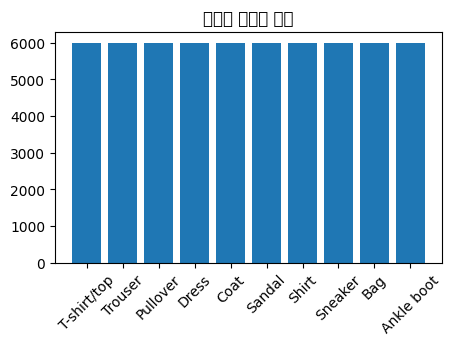

In [5]:
#label별 데이터 개수 (각각 6,000개)

# label별 데이터 개수를 저장할 딕셔너리 초기화
label_vis_dict = {}

# 각 클래스마다 데이터 개수를 세어 딕셔너리에 저장
for i in range(len(train_data.classes)):
    label_vis_dict[train_data.classes[i]] = len(train_data.train_labels[train_data.train_labels == i])

# 그래프를 생성
plt.figure(figsize=(5, 3))
plt.title("라벨별 데이터 개수")
plt.bar(label_vis_dict.keys(), label_vis_dict.values())  # 막대 그래프 생성
plt.xticks(rotation=45)  # x축 눈금을 45도 회전
plt.show()  # 그래프 표시


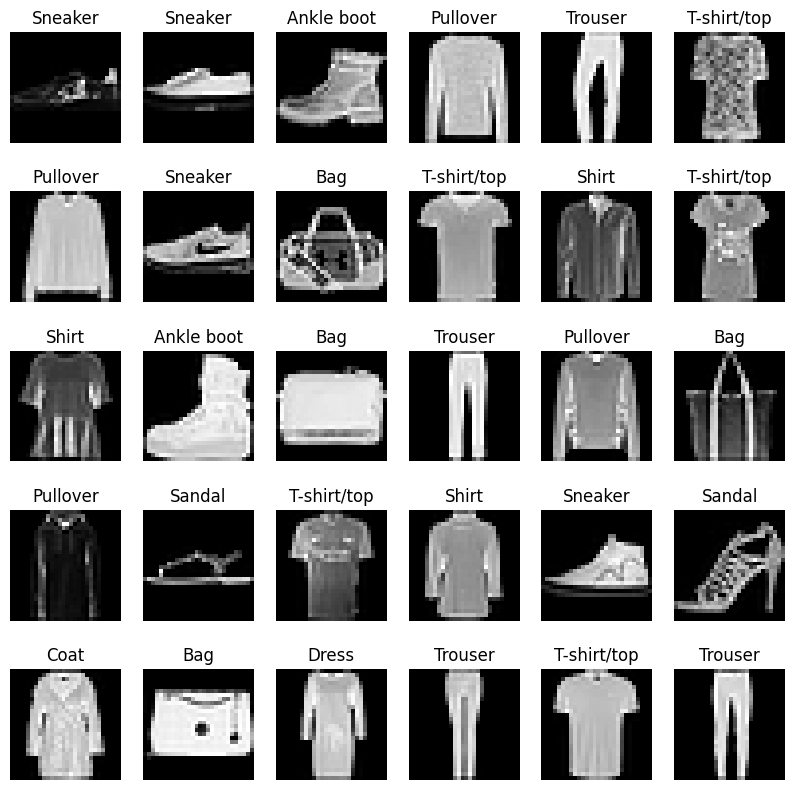

In [6]:
#Fashion MNIST 데이터셋 안의 의류 데이터 이미지 출력

figure = plt.figure(figsize=(10, 10))
cols, rows = 6, 5

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data.train_data), size=(1,)).item()  # 이미지 데이터셋의 길이를 기준으로 샘플 인덱스 생성
    image = train_data.train_data[sample_idx]  # 올바른 인덱싱을 사용하여 이미지 가져옴
    label = train_data.train_labels[sample_idx].item()  # 레이블 데이터에서 해당 인덱스의 레이블 가져옴

    # 이미지를 표시할 subplot 추가
    ax = figure.add_subplot(rows, cols, i)
    plt.title(train_data.classes[label])
    plt.axis("off")
    plt.imshow(image.squeeze(), cmap="gray")

plt.show()

In [7]:
# train_test_split 함수를 사용하여 데이터셋을 train, valid, test 데이터로 분할
x_train, x_valid, y_train, y_valid = train_test_split(train_data.train_data, train_data.train_labels, train_size=0.7, random_state=123)
x_test, y_test = test_data.test_data, test_data.test_labels

# 각 데이터의 형태 출력
print("x train shape: {}\ny train shape: {}\n".format(x_train.shape, y_train.shape))
print("x valid shape: {}\ny valid shape: {}\n".format(x_valid.shape, y_valid.shape))
print("x  test shape: {}\ny  test shape: {}".format(x_test.shape, y_test.shape))


x train shape: torch.Size([42000, 28, 28])
y train shape: torch.Size([42000])

x valid shape: torch.Size([18000, 28, 28])
y valid shape: torch.Size([18000])

x  test shape: torch.Size([10000, 28, 28])
y  test shape: torch.Size([10000])


In [8]:
# 데이터를 모델의 입력 형식에 맞게 전처리
# 각 데이터를 (배치 크기, 채널 수, 높이, 너비)의 형태로 재구성하고, 0에서 1 사이의 값으로 정규화

x_train = x_train.reshape(x_train.shape[0], 1, 28, 28).float() / 255
x_valid = x_valid.reshape(x_valid.shape[0], 1, 28, 28).float() / 255
x_test = x_test.reshape(x_test.shape[0], 1, 28, 28).float() / 255

# 전처리된 데이터의 형태 출력
print(f"x train shape: {x_train.shape}\nx valid shape: {x_valid.shape}\nx test shape: {x_test.shape}")

x train shape: torch.Size([42000, 1, 28, 28])
x valid shape: torch.Size([18000, 1, 28, 28])
x test shape: torch.Size([10000, 1, 28, 28])


In [9]:
# 훈련 데이터셋을 위한 DataLoader 객체 생성
train_dataset = TensorDataset(x_train, y_train)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,  # 배치 크기를 32로 설정
    shuffle=True,   # 데이터를 섞어줌
    num_workers=2,  # 데이터 로딩을 위한 worker의 수를 설정합니다.
)

# 검증 데이터셋을 위한 DataLoader 객체 생성
valid_dataset = TensorDataset(x_valid, y_valid)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=32,  # 배치 크기를 32로 설정
    shuffle=True,   # 데이터를 섞어줌
    num_workers=2,  # 데이터 로딩을 위한 worker의 수를 설정
)


In [10]:
#컨볼루션 신경망 클래스 정의

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # 합성곱 신경망의 각 층을 정의합니다.
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2))
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2))
        )
        self.flatten = nn.Flatten()
        self.layer3 = nn.Sequential(
            nn.Linear(in_features=1568, out_features=512),
            nn.ReLU()
        )
        self.classifier = nn.Linear(in_features=512, out_features=10)

    def forward(self, input):
        """
        신경망을 통해 입력 데이터를 전달

        매개변수:
            input: Tensor - 입력 데이터 (배치 크기, 채널 수, 높이, 너비)
            input shape: (3, 32, 32)

        반환값:
            output: Tensor - 출력 로짓 (배치 크기, 클래스 수)
            output shape: (10)
        """
        x = self.layer1(input)
        x = self.layer2(x)
        x = self.flatten(x)
        x = self.layer3(x)
        x = self.classifier(x)
        return x
    
# CNN 모델을 인스턴스화하고 적절한 장치로 이동
model = CNN().to(device)

In [11]:
# 모델의 요약 생성
# input_size=(1, 28, 28)는 입력 이미지의 크기
# 여기서 1은 채널 수 (흑백 이미지이므로), 28은 이미지의 높이, 28은 이미지의 너비를 나타냄

summary(model, input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]           9,248
              ReLU-5           [-1, 32, 14, 14]               0
         MaxPool2d-6             [-1, 32, 7, 7]               0
           Flatten-7                 [-1, 1568]               0
            Linear-8                  [-1, 512]         803,328
              ReLU-9                  [-1, 512]               0
           Linear-10                   [-1, 10]           5,130
Total params: 818,026
Trainable params: 818,026
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.56
Params size (MB): 3.12
Estimated T

In [12]:
# optimizer (adam optmizer)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# loss function (cross entropy loss function)
criterion = torch.nn.CrossEntropyLoss().to(device)

In [13]:
history = {"train_loss":[], "train_acc":[], "valid_loss":[], "valid_acc":[]}

# 30번의 epoch 동안 반복
for epoch in range(30):
    # === 모델 훈련 ===
    model.train()  # 모델을 학습 모드로 설정
    train_loss, train_correct, train_total = 0, 0, 0
    
    # 훈련 데이터셋을 반복
    for x, y in train_loader:
        # 0. 기울기를 0으로 초기화
        optimizer.zero_grad()

        # 1. 데이터를 적절한 장치로 이동
        x, y = x.to(device), y.to(device)
        
        # 2. 예측
        y_pred = model(x)

        # 3. 손실 함수 계산
        loss = criterion(y_pred, y)

        # 4. 역전파 수행
        loss.backward()

        # 5. 경사하강법을 이용하여 파라미터를 업데이트
        optimizer.step()

        # 6. 손실과 정확도 기록
        train_loss += loss.item()
        _, pred = torch.max(y_pred.data, 1)
        train_total += y.size(0)
        train_correct += (pred == y).sum().item()
    train_loss /= len(train_loader.dataset)
    train_acc = 100.*train_correct/train_total
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)

    # === 모델 검증 ===
    model.eval()  # 모델을 평가 모드로 설정
    valid_loss, valid_correct, valid_total = 0, 0, 0
    
    # 검증 데이터셋에 대해 반복
    with torch.no_grad():
        for x, y in valid_loader:
            # 1. 데이터를 적절한 장치로 이동
            x, y = x.to(device), y.to(device)

            # 2. 예측
            y_pred = model(x)

            # 3. 손실 함수 계산
            loss = criterion(y_pred, y)

            # 4. 손실과 정확도 기록
            valid_loss += loss.item()
            _, pred = torch.max(y_pred.data, 1)
            valid_total += y.size(0)
            valid_correct += (pred == y).sum().item()
    valid_loss /= len(valid_loader.dataset)
    valid_acc = 100.*valid_correct/valid_total
    history["valid_loss"].append(valid_loss)
    history["valid_acc"].append(valid_acc)
    
    # 결과를 출력합니다.
    print(f"[Epoch: {epoch+1:3d}] <TRAIN> loss: {train_loss:.9f}, acc: {train_acc:5.2f}%", end="")
    print(f" | <VALID> loss: {valid_loss:.9f}, acc: {valid_acc:5.2f}%")


[Epoch:   1] <TRAIN> loss: 0.021464720, acc: 75.73% | <VALID> loss: 0.015175829, acc: 82.46%
[Epoch:   2] <TRAIN> loss: 0.013686497, acc: 84.16% | <VALID> loss: 0.012789279, acc: 85.54%


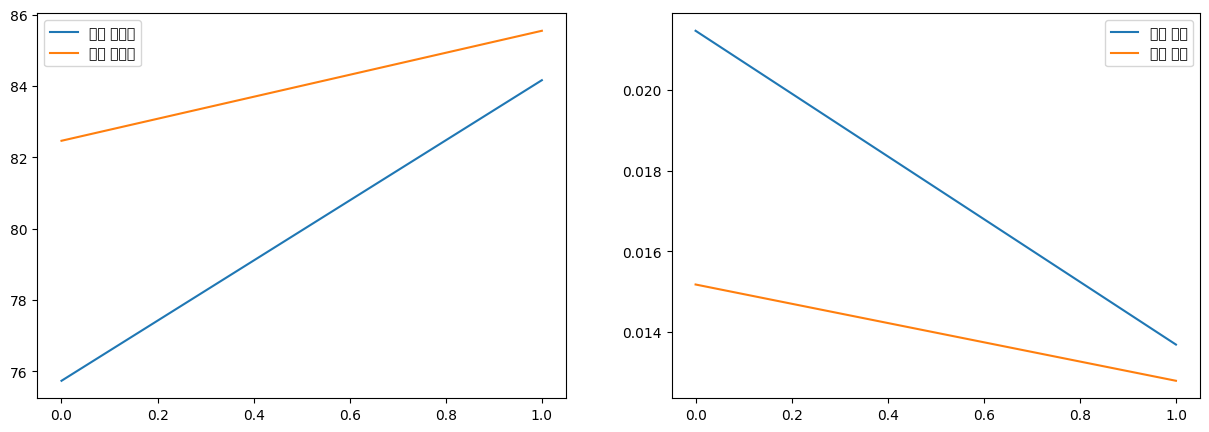

In [14]:
# 그래프 크기를 설정
plt.figure(figsize=(15,5))

# 첫 번째 subplot을 설정
plt.subplot(121)
plt.plot(history["train_acc"], label="훈련 정확도")  # 훈련 정확도를 나타냄
plt.plot(history["valid_acc"], label="검증 정확도")  # 검증 정확도를 나타냄
plt.legend()  # 범례 표시

# 두 번째 subplot을 설정
plt.subplot(122)
plt.plot(history["train_loss"], label="훈련 손실")  # 훈련 손실을 나타냄
plt.plot(history["valid_loss"], label="검증 손실")  # 검증 손실을 나타냄
plt.legend()  # 범례 표시

# 그래프 표시
plt.show()

In [15]:
# 모델을 평가 모드로 설정
model.eval()

# 데이터를 적절한 장치로 이동
x_test, y_test = x_test.to(device), y_test.to(device)

# 모델을 사용하여 예측 수행
y_pred = model(x_test)

# 손실 계산
loss = criterion(y_pred, y_test)

# 정확도 계산
_, pred = torch.max(y_pred.data, 1)
accuracy = 100.*(pred == y_test).sum().item() / len(pred)

# 결과 출력
print(f"Test loss\t: {loss.item():.9f}\nTest accuracy\t: {accuracy:5.2f}%")

Test loss	: 0.420509607
Test accuracy	: 84.99%


In [16]:
result_vis_dict = {"label": test_data.classes, "correct": [], "wrong": []}

# 클래스별로 반복
for i in range(len(test_data.classes)):
    # 클래스에 해당하는 인덱스 찾기
    y_indexes = (y_test == i).nonzero(as_tuple=True)[0]
    correct, wrong = 0, 0
    
    # 해당 클래스에 대한 인덱스를 반복
    for j in range(len(y_indexes)):
        # 예측이 정답과 일치하는지 확인하고 올바른 예측 수와 잘못된 예측 수 업데이트
        if pred[y_indexes[j]] == y_test[y_indexes[j]]:
            correct += 1
        else:
            wrong += 1
    
    # 올바른 예측 수와 잘못된 예측 수를 결과 딕셔너리에 추가
    result_vis_dict["correct"].append(correct)
    result_vis_dict["wrong"].append(wrong)


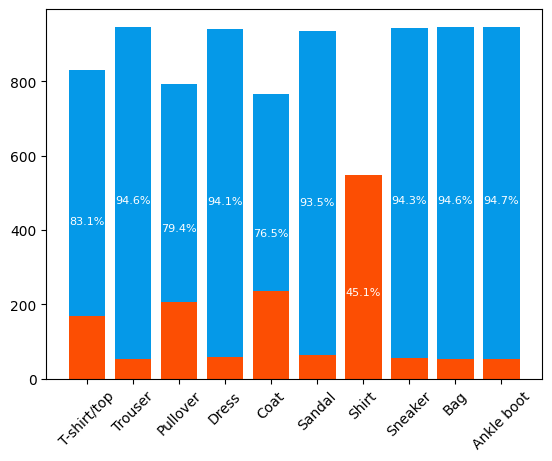

In [17]:
fig, ax = plt.subplots()

# 막대 그래프를 생성
ax.bar(test_data.classes, result_vis_dict["correct"], label="정답", color="#0599e8")  # 정답에 대한 막대 그래프를 그립니다.
ax.bar(test_data.classes, result_vis_dict["wrong"], label="오답", color="#fc4e03")  # 오답에 대한 막대 그래프를 그립니다.
plt.xticks(rotation=45)  # x축 눈금을 45도 회전

# 그래프에 정확도 표시
for i in range(len(result_vis_dict['label'])):
    ax.text(result_vis_dict['label'][i], result_vis_dict["correct"][i]/2, str(result_vis_dict['correct'][i]/10) + '%', fontsize=8, horizontalalignment='center', color='w')

# 그래프 표시
plt.show()